<a href="https://colab.research.google.com/github/Sandeep-4469/ML_Project/blob/main/ML_Project_TheMatrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O data.csv https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1&st=25jsg22t&dl=1

--2024-10-14 17:32:22--  https://www.dropbox.com/scl/fi/o7233oyy5ztnrq3kmolrj/DOM_hourly.csv?rlkey=8ax4e5ojld8ir5ivq9m8h9ag1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc64398633a48af76631ace2013.dl.dropboxusercontent.com/cd/0/inline/CceeJAvY1hfhKp_S7qDkJxngxjBHqXl-mqSl0zgkZ4kdkj8ljSRpMaXciBepMN738a-EccmX7ZDreBJ6nX-z85IFnLtMv3jTk2JyGBlM0RxDJF6fgQYIiJk_VdKHEijcsLrotj1Z-1n8ws0UfzW2zZ1T/file# [following]
--2024-10-14 17:32:23--  https://ucc64398633a48af76631ace2013.dl.dropboxusercontent.com/cd/0/inline/CceeJAvY1hfhKp_S7qDkJxngxjBHqXl-mqSl0zgkZ4kdkj8ljSRpMaXciBepMN738a-EccmX7ZDreBJ6nX-z85IFnLtMv3jTk2JyGBlM0RxDJF6fgQYIiJk_VdKHEijcsLrotj1Z-1n8ws0UfzW2zZ1T/file
Resolving ucc64398633a48af76631ace2013.dl.dropboxusercontent.com (ucc64398633a48af76631ace2013.dl.dropboxusercontent.com)... 162.125.5.15, 2620

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from pandas.plotting import autocorrelation_plot
from pandas.tseries.offsets import DateOffset

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb

In [3]:
df = pd.read_csv('data.csv')
df

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0
...,...,...
116184,2018-01-01 20:00:00,18418.0
116185,2018-01-01 21:00:00,18567.0
116186,2018-01-01 22:00:00,18307.0
116187,2018-01-01 23:00:00,17814.0


#EDA

In [4]:
df.isnull().sum()

,0
Datetime,0
DOM_MW,0


In [5]:
df.describe()

,DOM_MW
count,116189.000000
mean,10949.203625
std,2413.946569
min,1253.000000
25%,9322.000000
50%,10501.000000
75%,12378.000000
max,21651.000000


<Axes: >

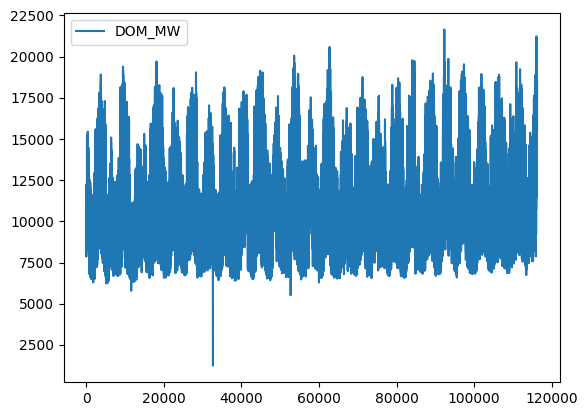

In [6]:
df.plot()

<Figure size 1000x600 with 0 Axes>

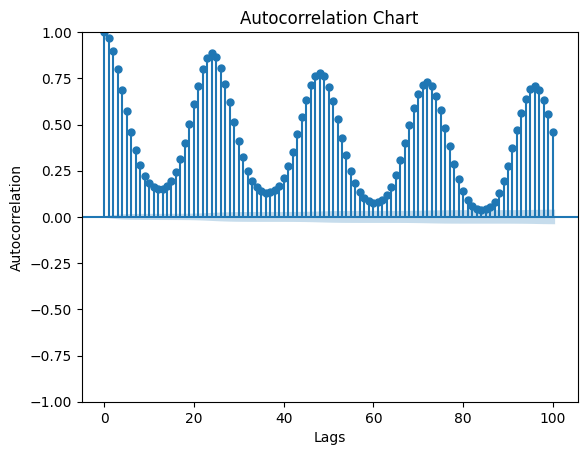

In [7]:
plt.figure(figsize=(10, 6))
plot_acf(df['DOM_MW'], lags=100)
plt.title('Autocorrelation Chart')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

<Figure size 2000x1200 with 0 Axes>

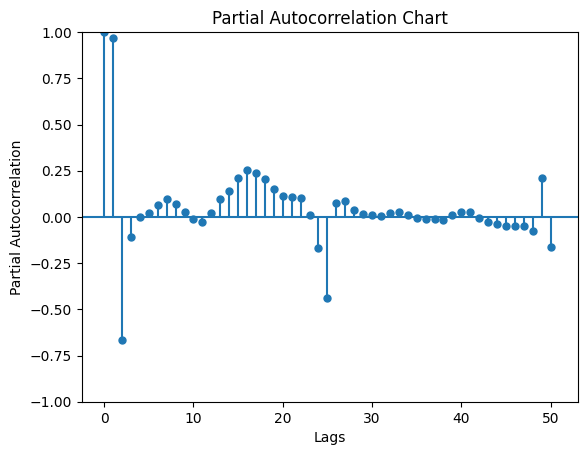

In [8]:
plt.figure(figsize=(20, 12))
plot_pacf(df['DOM_MW'], lags=50)
plt.title('Partial Autocorrelation Chart')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()

#Data Preprocessing

In [9]:
data = df.copy()
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('Datetime', inplace=True)

In [10]:
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['day_of_week'] = data.index.dayofweek
data['hour'] = data.index.hour
data['month'] = data.index.month
data['year'] = data.index.year

In [11]:
features = data[['day_of_year', 'day_of_month', 'day_of_week', 'hour', 'month', 'year']]
target = data['DOM_MW'].values

In [12]:
target_scaler = MinMaxScaler()
target_scaled = target_scaler.fit_transform(target.reshape(-1, 1))

In [13]:
split_index = int(len(features) * 0.8)

X_train, X_test = features[:split_index], features[split_index:]
y_train, y_test = target_scaled[:split_index], target_scaled[split_index:]

##Stationary Test

In [14]:
def is_stationary(series):
    adf_result = adfuller(series)
    return adf_result[1] <= 0.05

def make_stationary(series):
    differenced_data = series.copy()
    num_differences = 0

    while not is_stationary(differenced_data):
        differenced_data = differenced_data.diff().dropna()
        num_differences += 1
        print(f"Applied differencing: {num_differences}")

    return differenced_data

In [15]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Data has no unit root and is stationary")
        return 0
    else:
        print("Time series has a unit root, indicating it is non-stationary ")
        return 1

In [16]:
p = adfuller_test(df['DOM_MW'])

ADF Test Statistic : -15.006910125497667
p-value : 1.069441269623761e-27
#Lags Used : 71
Number of Observations Used : 116117
Data has no unit root and is stationary


In [17]:
if p==1:
  df_stat = make_stationary(df['DOM_MW'])

else:
  df_stat = df.copy()

##Selecting optimal lag from AutoCorrelation chart

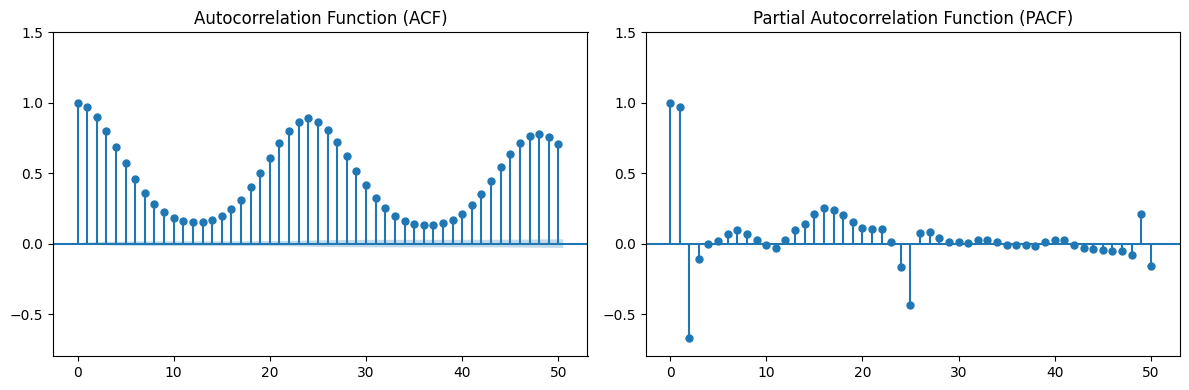

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(df_stat['DOM_MW'], lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.ylim((-.8, 1.5))
plt.tight_layout()

plt.subplot(1, 2, 2)
plot_pacf(df_stat['DOM_MW'], lags=50, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.ylim((-.8, 1.5))
plt.tight_layout()

plt.tight_layout()
plt.show()

#Models

##XGBOOST

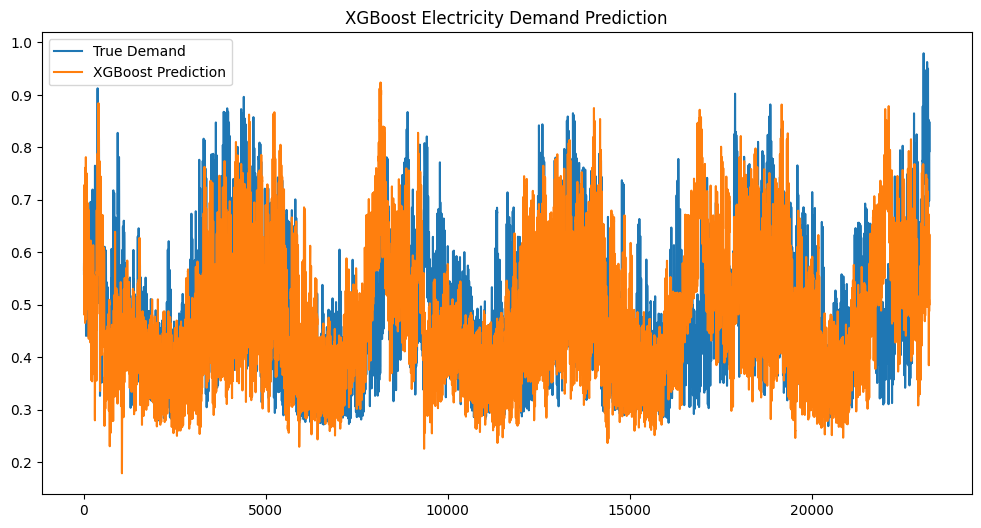

In [22]:
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.3, max_depth=6, reg_lambda=1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Demand')
plt.plot(xgb_pred, label='XGBoost Prediction')
plt.title('XGBoost Electricity Demand Prediction')
plt.legend()
plt.show()